# Colab Environment Setup

In [ ]:
## Setup Colab Environment
import sys
import gc
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')


from huggingface_hub import notebook_login
notebook_login()

## Download codebase
assert os.getcwd() == "/content"
if "PracVRL" not in os.listdir(os.getcwd()):
    !git clone https://github.com/egecimsir/PracVRL.git


## Adjust cwd and requirements
%cd PracVRL

## Download DDT-XL checkpoint if not exists
assert os.getcwd() == "/content/PracVRL"
if os.path.exists("model.ckpt"):
    print("Checkpoint found!")
else:
    !wget https://huggingface.co/MCG-NJU/DDT-XL-22en6de-R256/resolve/main/model.ckpt

!pip install -r requirements.txt
!pip install -U datasets
!pip install huggingface_hub
!git pull

sys.path.append("PracVRL")
sys.path.append("PracVRL/src")


FILE_URLS = [
    "https://www.cityscapes-dataset.com/file-handling/?packageID=1",  # gtFine_trainvaltest.zip (241MB)
    "https://www.cityscapes-dataset.com/file-handling/?packageID=3",  # leftImg8bit_trainvaltest.zip (11GB)
]


## GPU-memory management
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/PracVRL
Checkpoint found!
Already up to date.
Fri Jul 25 18:19:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disa

# Loading & Exploring CityScapes Dataset

## Load data from source

**IMPORTANT:** Don't forget to login on https://www.cityscapes-dataset.com/downloads/




In [2]:
DATA_DIR = "cityscapes"
FILE_URLS = [
    "https://www.cityscapes-dataset.com/file-handling/?packageID=1",  ## gtFine_trainvaltest.zip (241MB)
    "https://www.cityscapes-dataset.com/file-handling/?packageID=3",  ## leftImg8bit_trainvaltest.zip (11GB)
]
cookie = "PHPSESSID=vi6m4070fpbe6sfjb5i1sm1v6e"
headers = [
    'User-Agent: Mozilla/5.0 (YOUR-USER-AGENT-HERE)',
    f'Cookie: {cookie}'
]

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

    for i, url in enumerate(FILE_URLS):
        output_path = f"/content/PracVRL/cityscapes/{1 if str(1) in url else 3}.zip"
        header_flags = ' '.join([f'--header="{h}"' for h in headers])
        cmd = f'wget {header_flags} -O {output_path} "{url}"'
        os.system(cmd)


    !unzip /content/PracVRL/cityscapes/1.zip -d /content/PracVRL/cityscapes/1/
    !unzip /content/PracVRL/cityscapes/3.zip -d /content/PracVRL/cityscapes/3/
else:
    print("Data directory already exits.")


if "1" in os.listdir(DATA_DIR):
    !mv /content/PracVRL/cityscapes/1/* /content/PracVRL/cityscapes/
    !rm -r /content/PracVRL/cityscapes/1
    !rm -f /content/PracVRL/cityscapes/1.zip

if "3" in os.listdir(DATA_DIR):
    !mv /content/PracVRL/cityscapes/3/leftImg8bit /content/PracVRL/cityscapes/
    !rm -r /content/PracVRL/cityscapes/3
    !rm -f /content/PracVRL/cityscapes/3.zip


assert os.path.exists("/content/PracVRL/cityscapes/gtFine")
assert os.path.exists("/content/PracVRL/cityscapes/leftImg8bit")

Streaming output truncated to the last 5000 lines.
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: /content/PracVRL/cityscapes/3/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: /content/

## Load as torch dataset

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets import Cityscapes
from PIL import Image

train_set = Cityscapes(root="cityscapes", split="train", target_type=["semantic"])
test_set = Cityscapes(root="cityscapes", split="test", target_type=["semantic"])
val_set = Cityscapes(root="cityscapes", split="val", target_type=["semantic"])

print(train_set)
print(test_set)
print(val_set)

Dataset Cityscapes
    Number of datapoints: 2975
    Root location: cityscapes
    Split: train
    Mode: gtFine
    Type: ['semantic']
Dataset Cityscapes
    Number of datapoints: 1525
    Root location: cityscapes
    Split: test
    Mode: gtFine
    Type: ['semantic']
Dataset Cityscapes
    Number of datapoints: 500
    Root location: cityscapes
    Split: val
    Mode: gtFine
    Type: ['semantic']


## Explore

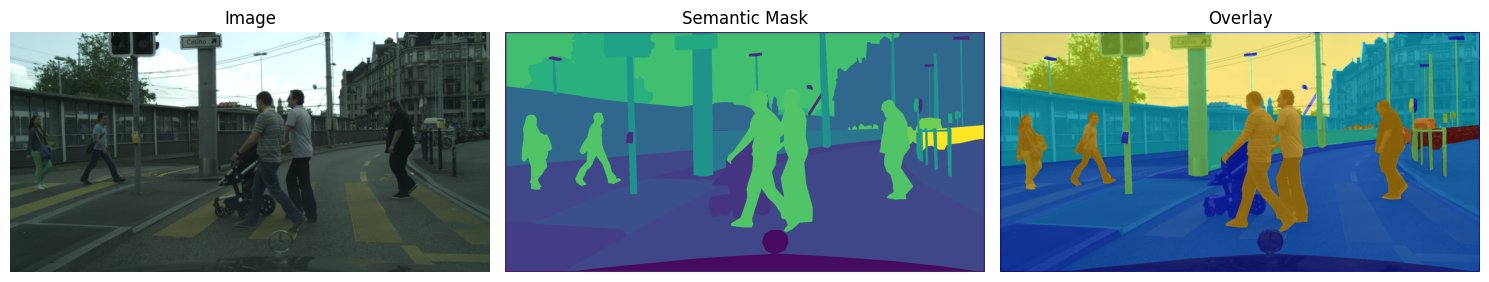

In [4]:
from torchvision.datasets import Cityscapes
from utils import overlay_mask


DATA_DIR = "cityscapes"
dataset = Cityscapes(DATA_DIR, target_type="semantic")

img, mask = dataset[0]
img = img.convert('RGB')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Semantic Mask")
plt.imshow(mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay_mask(img, mask))
plt.axis("off")

plt.tight_layout()
plt.show()

# Feature Extraction

In [45]:
import os
import gc

import torch
import torch.nn as nn
import torchvision.transforms as T

from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from extract_features import DDTWrapper
from myDatasets import CityscapesDataset
from tqdm import tqdm

In [46]:
DATA_DIR = "cityscapes"
FEAT_DIR = "cityscape_features_avg"
P_FEAT_DIR = "cityscape_features_patched"

CONF_PATH = "configs/repa_improved_ddt_xlen22de6_256.yaml"
CKPT_PATH = "model.ckpt"
device = "cuda" if torch.cuda.is_available() else "cpu"

TIME_STEPS = (0.95, 0.50)
SPLITS = ("train", "test", "val")

## Prepare Loops

In [47]:
def extract_features_1152(
        model: DDTWrapper,
        t_step: int,
        loader: DataLoader,
        output_dir: str,
        save_every: int = 10,
        device: str = "cuda",
    ):
    print(f"Extracting features using {device.upper()}")
    os.makedirs(output_dir, exist_ok=True)

    file_counter = 0

    ddt = model.ddt
    vae = model.vae
    scheduler = model.scheduler

    t0 = torch.tensor([t_step], device=device)
    a0 = scheduler.alpha(t0).view(-1,1,1,1).to(device)
    s0 = scheduler.sigma(t0).view(-1,1,1,1).to(device)

    activations = model.register_encoder_hook([])
    # Wrap data loading and model inference in torch.no_grad()
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader,
                        desc="Extracting Features",
                        total=len(loader.dataset) // loader.batch_size,
                        leave=True)
            ):
            x = x.to(device)
            y = y.to(device)

            z = vae.encode(x)
            noise = torch.randn_like(z)
            zt = a0 * z + s0 * noise
            y_idx = y.argmax(dim=1)

            _ = ddt(
                x=zt,
                t=torch.full((z.shape[0],), t_step, device=device, dtype=torch.float32),
                y=y_idx
            )

            del z, zt, noise
            torch.cuda.empty_cache()

            if len(activations) >= save_every:
                ## Save every act in activations list and empty list
                # Concatenate the activations along the batch dimension (dim 0)
                act_chunk = torch.cat(activations[:save_every], dim=0).cpu()
                save_path = os.path.join(output_dir, f"features_{file_counter:05d}.pt")
                torch.save(act_chunk, save_path)

                ## delete items
                activations[:] = activations[save_every:]
                file_counter += 1

        ## Save any remaining activations
        if len(activations) > 0:
            # Concatenate the remaining activations along the batch dimension (dim 0)
            act_chunk = torch.cat(activations, dim=0).cpu()
            save_path = os.path.join(output_dir, f"features_{file_counter:05d}.pt")
            torch.save(act_chunk, save_path)

    print("Extracted!")



def extract_features_196_1152(
        model: DDTWrapper,
        t_step: int,
        loader: DataLoader,
        output_dir: str,
        save_every: int = 10,
        device: str = "cuda",
    ):
    print(f"Extracting features using {device.upper()}")
    os.makedirs(output_dir, exist_ok=True)

    file_counter = 0

    ddt = model.ddt
    vae = model.vae
    scheduler = model.scheduler

    t0 = torch.tensor([t_step], device=device)
    a0 = scheduler.alpha(t0).view(-1,1,1,1).to(device)
    s0 = scheduler.sigma(t0).view(-1,1,1,1).to(device)

    activations = model.register_encoder_hook([])
    # Wrap data loading and model inference in torch.no_grad()
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader,
                        desc="Extracting Features",
                        total=len(loader.dataset) // loader.batch_size,
                        leave=True)
            ):
            x = x.to(device)
            y = y.to(device)

            z = vae.encode(x)
            noise = torch.randn_like(z)
            zt = a0 * z + s0 * noise
            y_idx = y.argmax(dim=1)

            _ = ddt(
                x=zt,
                t=torch.full((z.shape[0],), t_step, device=device, dtype=torch.float32),
                y=y_idx
            )

            del z, zt, noise
            torch.cuda.empty_cache()

            if len(activations) >= save_every:
                ## Save every act in activations list and empty list
                # Concatenate the activations along the batch dimension (dim 0)
                act_chunk = torch.cat(activations[:save_every], dim=0).cpu()
                save_path = os.path.join(output_dir, f"features_{file_counter:05d}.pt")
                torch.save(act_chunk, save_path)

                ## delete items
                activations[:] = activations[save_every:]
                file_counter += 1

        ## Save any remaining activations
        if len(activations) > 0:
            # Concatenate the remaining activations along the batch dimension (dim 0)
            act_chunk = torch.cat(activations, dim=0).cpu()
            save_path = os.path.join(output_dir, f"features_{file_counter:05d}.pt")
            torch.save(act_chunk, save_path)

    print("Extracted!")

In [48]:
def extract_cityscapes_features(
    model,
    device,
    data_dir,
    patched = True,
    output_dir_base="cityscapes_features_patched",
    time_steps=[0.95, 0.50],
    target_type="semantic",
    splits=("test", "train", "val"),
    batch_size=64,
    save_every=5,
):
    """
    Extracts patch-based features from Cityscapes images and saves them.

    Args:
        model: Feature extractor model.
        device: "cuda" or "cpu".
        data_dir: Path to Cityscapes dataset.
        output_dir_base: Base directory to store extracted features.
        time_steps: List of diffusion or noise timesteps (e.g., [0.95]).
        target_type: Type of target (e.g., "semantic", unused here but retained).
        splits: Dataset splits to process ("train", "val", "test").
        batch_size: Batch size for dataloader.
        save_every: Save frequency in batches.
        image_transforms: Optional image transforms.
        target_transforms: Optional target transforms.
    """

    if device != "cuda":
        print("Device is not CUDA. Aborting feature extraction.")
        return

    for split in splits:
        output_dir = os.path.join(output_dir_base, split)
        os.makedirs(output_dir, exist_ok=True)

        print(f"\n[INFO] Extracting features for split: {split}")
        gc.collect()
        torch.cuda.empty_cache()

        dataset = CityscapesDataset(
            root_dir=data_dir,
            split=split,

        )
        dataloader = DataLoader(dataset, batch_size=batch_size)

        for t in time_steps:
            out_path = os.path.join(output_dir, f"timestep_{int(t * 100)}")
            os.makedirs(out_path, exist_ok=True)
            print(f"[INFO] Saving features to: {out_path}")

            if patched:
                extract_features_196_1152(
                    model=model,
                    t_step=t,
                    loader=dataloader,
                    output_dir=out_path,
                    save_every=save_every,
                    device=device
                )
            else:
                extract_features_1152(
                    model=model,
                    t_step=t,
                    loader=dataloader,
                    output_dir=out_path,
                    save_every=save_every,
                    device=device
                )

            print(f"[✓] Done extracting for timestep {t}\n")

    print("[✓] All extractions complete.")

## Loading DDT model

In [49]:
gc.collect()
torch.cuda.empty_cache()
print(f"Device: {device.upper()}")


model = DDTWrapper(
    config_path=CONF_PATH,
    ckpt_path=CKPT_PATH,
    device=device
)
if device == "cuda" and torch.cuda.device_count() > 1:
    ## Fully sharded data parallel
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP

    model.vae = FSDP(model.vae)
    model.ddt = FSDP(model.ddt)
    model.conditioner = FSDP(model.conditioner)
    model.sampler = FSDP(model.sampler)
    model.diff_trainer = FSDP(model.diff_trainer)
    print("Model -> FSDP")

model.to_eval()

ddt = model.ddt
print(ddt)

Device: CUDA

---------------
Initializing ddt, vae, conditioner


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights...


/content/PracVRL/extract_features.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


Loaded 349/349 weights.
Initializing diffusion trainer, sampler, scheduler


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Number of encoder blocks: 22

Completed!
---------------

DDT(
  (x_embedder): Embed(
    (proj): Linear(in_features=16, out_features=1152, bias=True)
    (norm): Identity()
  )
  (s_embedder): Embed(
    (proj): Linear(in_features=16, out_features=1152, bias=True)
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1152, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1152, out_features=1152, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 1152)
  )
  (final_layer): FinalLayer(
    (norm_final): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
    (linear): Linear(in_features=1152, out_features=16, bias=True)
    (adaLN_modulation): Sequential(
      (0): Linear(in_features=1152, out_features=2304, bias=True)
    )
  )
  (blocks): ModuleList(
    (0-27): 28 x DDTBlock(
      (norm1): RMSNorm()
      (attn): RAttention(
        (qkv): Linear(in_fe

## Extraction

Features of shape (1152)

In [10]:
extract_cityscapes_features(
    model=model,
    device=device,
    data_dir=DATA_DIR,
    patched = False,
    output_dir_base=FEAT_DIR,
    time_steps=TIME_STEPS,
    splits=SPLITS,
)


[INFO] Extracting features for split: train
[INFO] Saving features to: cityscape_features_avg/train/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 47it [05:59,  7.64s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_avg/train/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 47it [06:00,  7.68s/it]


Extracted!
[✓] Done extracting for timestep 0.5


[INFO] Extracting features for split: test
[INFO] Saving features to: cityscape_features_avg/test/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 24it [03:02,  7.59s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_avg/test/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 24it [03:04,  7.68s/it]


Extracted!
[✓] Done extracting for timestep 0.5


[INFO] Extracting features for split: val
[INFO] Saving features to: cityscape_features_avg/val/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 8it [01:02,  7.78s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_avg/val/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 8it [01:02,  7.84s/it]


Extracted!
[✓] Done extracting for timestep 0.5

[✓] All extractions complete.


Features of shape (196, 1152)

In [ ]:
extract_cityscapes_features(
    model=model,
    device=device,
    data_dir=DATA_DIR,
    patched = True,
    output_dir_base=P_FEAT_DIR,
    time_steps=TIME_STEPS,
    splits=SPLITS,
)


[INFO] Extracting features for split: train
[INFO] Saving features to: cityscape_features_patched/train/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 47it [06:13,  7.94s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_patched/train/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 47it [06:13,  7.95s/it]


Extracted!
[✓] Done extracting for timestep 0.5


[INFO] Extracting features for split: test
[INFO] Saving features to: cityscape_features_patched/test/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 24it [03:11,  7.96s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_patched/test/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 24it [03:11,  7.97s/it]


Extracted!
[✓] Done extracting for timestep 0.5


[INFO] Extracting features for split: val
[INFO] Saving features to: cityscape_features_patched/val/timestep_95
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 8it [01:04,  8.06s/it]


Extracted!
[✓] Done extracting for timestep 0.95

[INFO] Saving features to: cityscape_features_patched/val/timestep_50
Extracting features using CUDA
Hook registered for layer: ddt.blocks.21


Extracting Features: 8it [01:06,  8.31s/it]


# Semantic Segmentation Probe on Time-Dependent Features

In [89]:
import os
import gc
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from tqdm import tqdm

## Define Datasets

In [97]:
def map_labels_to_trainIds(label_tensor, mapping):
    # Vectorized mapping for efficiency
    out = label_tensor.clone()
    for label_id, train_id in mapping.items():
        out[label_tensor == label_id] = train_id
    return out


class FeatureDataset(Dataset):
    def __init__(self, feat_dir, mask_dir, split, timestep: float, feat_transform=None):
        assert 0.0 <= timestep <= 1.0
        self.feat_dir = os.path.join(feat_dir, split, f"timestep_{int(timestep*100)}")
        self.mask_dir = os.path.join(mask_dir, "gtFine", split)
        self.split = split
        self.timestep = timestep

        ## Get features as tensors
        feature_paths = []
        for pt_file in os.listdir(self.feat_dir):
            path = os.path.join(self.feat_dir, pt_file)
            if os.path.isfile(path) and path.endswith(".pt"):
                feature_paths.append(path)

        features = []
        for path in feature_paths:
            batch = torch.load(path)
            features.append(batch)

        self.features = torch.cat(features, dim=0)
        del features

        ## Get seg_mask paths
        mask_paths = []
        for city in os.listdir(self.mask_dir):
            city_path = os.path.join(self.mask_dir, city)
            for fpath in os.listdir(city_path):
                if "labelIds" in fpath:
                    lbl_path = os.path.join(city_path, fpath)
                    mask_paths.append(lbl_path)

        mask_paths = sorted(mask_paths)

        assert len(mask_paths) == len(self.features), f"Mismatched files! features={len(self.features)} | masks={len(mask_paths)}"

        self.mask_paths = mask_paths

        ## Transforms
        self.feat_transform = feat_transform
        # Modified mask_transform sequence
        self.mask_transform = T.Compose([
            T.PILToTensor(),                                        # Convert PIL Image to tensor (1, H, W)
            T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST), # Resize first while still (1, H, W)
            T.Lambda(lambda x: x.squeeze(0).long()),                # Remove channel dim and convert to long (H, W)
            T.Lambda(lambda x: map_labels_to_trainIds(x, CityscapesDataset.label2trainId)), # Map labels (0-18, 19 for ignore)
            # Set ignore_index (19) to -1 for CrossEntropyLoss
            T.Lambda(lambda x: torch.where(x == 19, torch.tensor(-1, dtype=torch.long), x)),
        ])


    def __len__(self):
        return len(self.features)


    def __getitem__(self, idx):
        feat = self.features[idx]
        mask = Image.open(self.mask_paths[idx])

        if self.feat_transform is not None:
            feat = self.feat_transform(feat)

        # Apply the modified mask_transform
        mask = self.mask_transform(mask)

        return feat, mask


class PatchedFeatureDataset(Dataset):
    def __init__(self, feat_dir, mask_dir, split, timestep: float):
        assert 0.0 <= timestep <= 1.0
        self.feat_dir = os.path.join(feat_dir, split, f"timestep_{int(timestep*100)}")
        self.mask_dir = os.path.join(mask_dir, "gtFine", split)
        self.split = split
        self.timestep = timestep

        ## Get features as tensors
        feature_paths = []
        for pt_file in os.listdir(self.feat_dir):
            path = os.path.join(self.feat_dir, pt_file)
            if os.path.isfile(path) and path.endswith(".pt"):
                feature_paths.append(path)

        features = []
        for path in feature_paths:
            batch = torch.load(path)
            features.append(batch)

        self.features = torch.cat(features, dim=0)
        del features

        ## Get seg_mask paths
        mask_paths = []
        for city in os.listdir(self.mask_dir):
            city_path = os.path.join(self.mask_dir, city)
            for fpath in os.listdir(city_path):
                if "labelIds" in fpath:
                    lbl_path = os.path.join(city_path, fpath)
                    mask_paths.append(lbl_path)

        mask_paths = sorted(mask_paths)

        assert len(mask_paths) == len(self.features), f"Mismatched files! features={len(self.features)} | masks={len(mask_paths)}"

        self.mask_paths = mask_paths

        ## Transforms
        self.feat_transform = T.Compose([
            T.Lambda(lambda x: x.view(196, 1152))
        ])

        # Modified mask_transform sequence
        self.mask_transform = T.Compose([
            T.PILToTensor(),                                        # Convert PIL Image to tensor (1, H, W)
            T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST), # Resize first while still (1, H, W)
            T.Lambda(lambda x: x.squeeze(0).long()),                # Remove channel dim and convert to long (H, W)
            T.Lambda(lambda x: map_labels_to_trainIds(x, CityscapesDataset.label2trainId)), # Map labels (0-18, 19 for ignore)
            # Set ignore_index (19) to -1 for CrossEntropyLoss
            T.Lambda(lambda x: torch.where(x == 19, torch.tensor(-1, dtype=torch.long), x)),
        ])


    def __len__(self):
        return len(self.features)


    def __getitem__(self, idx):
        feat = self.feat_transform(self.features[idx])
        mask = self.mask_transform(Image.open(self.mask_paths[idx]))

        return feat, mask

## Define Segmentation Models

In [91]:
class SegmentationHead(nn.Module):
    def __init__(self, in_dim=1152, n_class=19, out_size=224):
        super().__init__()
        self.n_class = n_class
        self.out_size = out_size

        # Reshape flat vector to feature map
        self.feature_dim = (128, 3, 3)  # 128×3×3 = 1152

        # Convolutional decoder to upsample to 224×224
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 6×6
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 12×12
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 24×24
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # 48×48
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, n_class, kernel_size=4, stride=2, padding=1), # 96×96
            nn.Upsample(size=(out_size, out_size), mode='bilinear', align_corners=False)  # final 224×224
        )

    def forward(self, x):
        B = x.size(0)                     ## x: (B, 1152)
        x = x.view(B, *self.feature_dim)  ## (B, 128, 3, 3)
        logits = self.decoder(x)          ## (B, n_class, 224, 224)
        return logits



class PatchedSegmentationHead(nn.Module):
    def __init__(self, in_dim=1152, n_class=19, patch_size=16, out_size=224):
        super().__init__()
        self.in_dim = in_dim
        self.n_class = n_class
        self.patch_size = patch_size
        self.resolution = out_size // patch_size

        ## Modules
        self.project = nn.Sequential(
            nn.Linear(in_dim, n_class),
            nn.SiLU()
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(n_class, n_class, kernel_size=patch_size, stride=patch_size),
            nn.ReLU(),
            nn.BatchNorm2d(n_class)
        )

    def forward(self, x: Tensor):
        B, N, d = x.shape                     ## (B, 196, 1152)
        H = W = self.resolution               ## 224

        x = self.project(x).permute(0, 2, 1)  ## (B, n_class, 14, 14)
        x = x.view(B, self.n_class, H, W)     ## (B, n_class, 14, 14)

        return self.upsample(x)               ## (B, n_class, 224, 224)

## Define Training Functions

Metrics:

In [92]:
def compute_iou(preds, labels, num_classes, device):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1).to(device)

    # Create mask for valid pixels (not ignore index -1)
    valid_mask = labels != -1
    preds = preds[valid_mask]
    labels = labels[valid_mask]

    if len(labels) == 0:
        return [float('nan')] * num_classes

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return ious


def pixel_accuracy(preds, labels):
    # Create mask for valid pixels (not ignore index -1)
    valid_mask = labels != -1
    if valid_mask.sum() == 0:
        return 0.0

    labels = labels.to(preds.device)
    correct = (preds[valid_mask] == labels[valid_mask]).sum().item()
    total = valid_mask.sum().item()

    return correct / total

Main functions:

In [93]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        # Ensure masks are long type for CrossEntropyLoss
        masks = masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device, num_classes=19):
    model.eval()
    total_loss = 0.0
    total_iou = []
    total_acc = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            # Ensure masks are long type for CrossEntropyLoss
            masks = masks.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            # Pass device to compute_iou and pixel_accuracy
            ious = compute_iou(preds, masks, num_classes, device)
            acc = pixel_accuracy(preds, masks)

            total_iou.append(ious)
            total_acc.append(acc)

    mean_iou = np.nanmean(np.array(total_iou), axis=0)
    overall_acc = np.mean(total_acc)
    return total_loss / len(dataloader), mean_iou, overall_acc



def run_training_loop(
    model: nn.Module,
    train_set: Dataset,
    test_set: Dataset,
    epochs=8,
    lr=0.001,
    batch_size=128,
    device="cuda",
    num_workers=4
):

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    # Initialize metric lists
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_mean_ious = []

    # Instantiate model, optimizer, loss
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_loss, mean_iou, val_acc = evaluate(model, test_loader, loss_fn, device, 19)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_mean_ious.append(np.nanmean(mean_iou))

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Pixel Accuracy: {val_acc:.4f}")
        print(f"Val Mean IoU: {np.nanmean(mean_iou):.4f}")

    print("Done!")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_mean_ious': val_mean_ious
    }

In [104]:
METRIC_DIR = "train_metrics"
MODEL_DIR = "segmentation_models"
TIME_STEPS = (0.95, 0.50)
EPOCHS = 8
L_RATE = 0.001
B_SIZE = 128

os.makedirs(METRIC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Segmentation with Patched Features

In [105]:
gc.collect()
torch.cuda.empty_cache()


for timestep in TIME_STEPS:
    ## Load data
    train_set = PatchedFeatureDataset(P_FEAT_DIR, DATA_DIR, split="train", timestep=timestep)
    test_set = PatchedFeatureDataset(P_FEAT_DIR, DATA_DIR, split="test", timestep=timestep)

    dataset = ConcatDataset([train_set, test_set])
    validation_set = PatchedFeatureDataset(P_FEAT_DIR, DATA_DIR, split="val", timestep=timestep)
    del train_set, test_set

    ## Get model
    model = PatchedSegmentationHead()

    ## Main
    metrics = run_training_loop(
        model=model,
        train_set=dataset,
        test_set=validation_set,
        epochs=EPOCHS,
        lr=L_RATE,
        batch_size=B_SIZE
    )

    ## Save model
    torch.save(model, os.path.join(MODEL_DIR, f"model_{int(timestep*100)}_patched.pt"))

    # Save to JSON
    path = os.path.join(METRIC_DIR, f"metrics_{int(timestep*100)}_patched.json")
    with open(path, 'w') as f:
        json.dump(metrics, f, indent=2)

    # Access the metrics
    print("Training losses:", metrics['train_losses'])
    print("Validation losses:", metrics['val_losses'])
    print("Validation accuracies:", metrics['val_accuracies'])
    print("Validation mean IoUs:", metrics['val_mean_ious'])

/tmp/ipython-input-97-2466999821.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(path)



Epoch 1/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 107.89it/s]


Train Loss: 2.7686
Val Loss: 2.7508
Val Pixel Accuracy: 0.4917
Val Mean IoU: 0.0630

Epoch 2/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 107.95it/s]


Train Loss: 1.8165
Val Loss: 1.7929
Val Pixel Accuracy: 0.5707
Val Mean IoU: 0.0901

Epoch 3/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 107.17it/s]


Train Loss: 1.6388
Val Loss: 1.4969
Val Pixel Accuracy: 0.5919
Val Mean IoU: 0.0979

Epoch 4/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 108.65it/s]


Train Loss: 1.5628
Val Loss: 1.4615
Val Pixel Accuracy: 0.5882
Val Mean IoU: 0.0951

Epoch 5/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 110.52it/s]


Train Loss: 1.5101
Val Loss: 1.4293
Val Pixel Accuracy: 0.5895
Val Mean IoU: 0.0951

Epoch 6/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 108.17it/s]


Train Loss: 1.4563
Val Loss: 1.3315
Val Pixel Accuracy: 0.6038
Val Mean IoU: 0.0945

Epoch 7/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 108.11it/s]


Train Loss: 1.4283
Val Loss: 1.3705
Val Pixel Accuracy: 0.5916
Val Mean IoU: 0.0980

Epoch 8/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 107.01it/s]


Train Loss: 1.3911
Val Loss: 1.3385
Val Pixel Accuracy: 0.6119
Val Mean IoU: 0.1029
Done!
Training losses: [2.76863686243693, 1.8164504037963018, 1.6388193402025435, 1.5627508858839672, 1.510132951868905, 1.4562667806943257, 1.42833345135053, 1.3910654054747686]
Validation losses: [2.7508456168174744, 1.7929465191364289, 1.496852888584137, 1.4614916133880616, 1.4293013429641723, 1.33153535592556, 1.370465223789215, 1.3385112829208374]
Validation accuracies: [np.float64(0.49173688209449495), np.float64(0.5707291631036321), np.float64(0.5919274096691708), np.float64(0.5881987854365528), np.float64(0.5894510464748873), np.float64(0.6037570466784673), np.float64(0.5916114589082088), np.float64(0.6119305303114736)]
Validation mean IoUs: [np.float64(0.06302830358938805), np.float64(0.09009462290537698), np.float64(0.09787155469221712), np.float64(0.09511111212681739), np.float64(0.09514801763105556), np.float64(0.09452674060467971), np.float64(0.09799230189524308), np.float64(0.1028521910397

Evaluating: 100%|██████████| 500/500 [00:04<00:00, 109.59it/s]


Train Loss: 2.6602
Val Loss: 2.7124
Val Pixel Accuracy: 0.5063
Val Mean IoU: 0.0591

Epoch 2/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 108.36it/s]


Train Loss: 1.8030
Val Loss: 1.9215
Val Pixel Accuracy: 0.5271
Val Mean IoU: 0.0739

Epoch 3/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 110.12it/s]


Train Loss: 1.6673
Val Loss: 1.6861
Val Pixel Accuracy: 0.5346
Val Mean IoU: 0.0798

Epoch 4/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 110.57it/s]


Train Loss: 1.5898
Val Loss: 1.6939
Val Pixel Accuracy: 0.5244
Val Mean IoU: 0.0801

Epoch 5/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 112.00it/s]


Train Loss: 1.5289
Val Loss: 1.5553
Val Pixel Accuracy: 0.5608
Val Mean IoU: 0.0848

Epoch 6/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 110.47it/s]


Train Loss: 1.4896
Val Loss: 1.6428
Val Pixel Accuracy: 0.5157
Val Mean IoU: 0.0778

Epoch 7/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 108.18it/s]


Train Loss: 1.4482
Val Loss: 1.4964
Val Pixel Accuracy: 0.5576
Val Mean IoU: 0.0846

Epoch 8/8


Evaluating: 100%|██████████| 500/500 [00:04<00:00, 106.26it/s]

Train Loss: 1.4226
Val Loss: 1.3868
Val Pixel Accuracy: 0.5745
Val Mean IoU: 0.0762
Done!
Training losses: [2.6602061490217843, 1.8029823435677423, 1.6673026118013594, 1.5898179047637515, 1.5288511845800612, 1.489579935868581, 1.4482110506958432, 1.4225578573015]
Validation losses: [2.7123738985061645, 1.9215335307121277, 1.6860908660888672, 1.693946529865265, 1.5552542459964753, 1.6427920417785644, 1.4963877863883972, 1.386822441101074]
Validation accuracies: [np.float64(0.5062757174367003), np.float64(0.5270666281942827), np.float64(0.5346495061848248), np.float64(0.5243982014474534), np.float64(0.5608052272697563), np.float64(0.5156605430602547), np.float64(0.5575662885811742), np.float64(0.574491659967266)]
Validation mean IoUs: [np.float64(0.059142154195415915), np.float64(0.07393857422917939), np.float64(0.07984058756627826), np.float64(0.08010572340808467), np.float64(0.0847952127921368), np.float64(0.07784733680553702), np.float64(0.08459751370790247), np.float64(0.076151546885

# Visualise Outputs

/tmp/ipython-input-106-1513167885.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(MODEL_DIR, f"model_{int(t*100)}_patched.pt"))
/tmp/ipyt

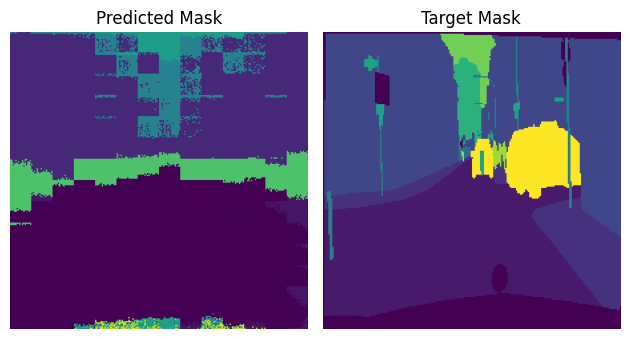

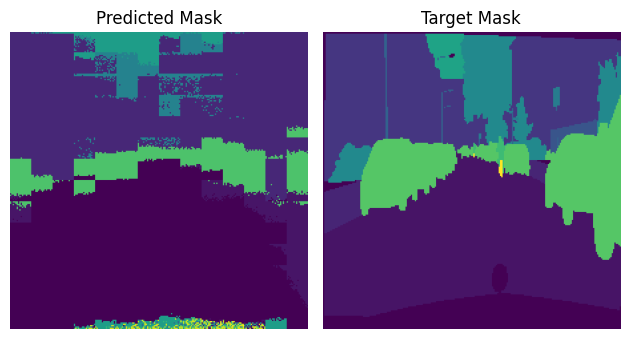

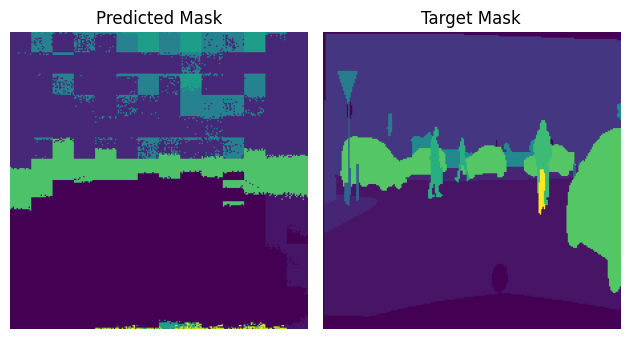

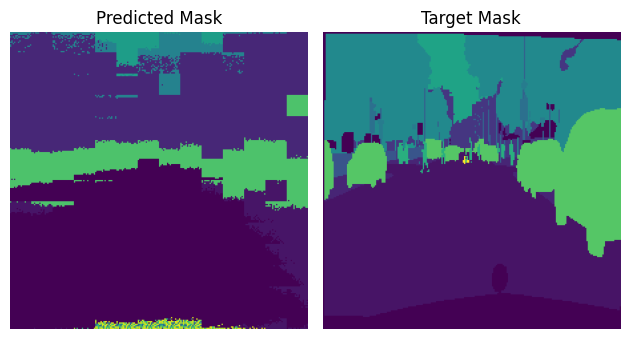

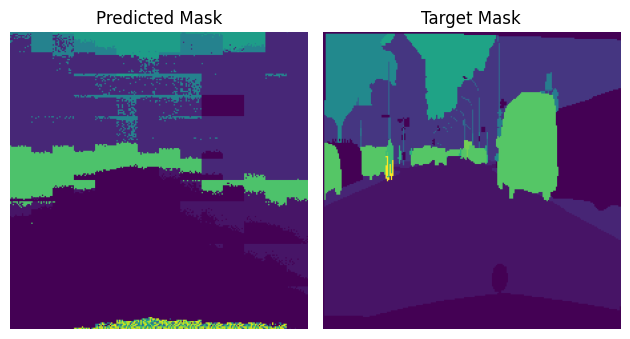

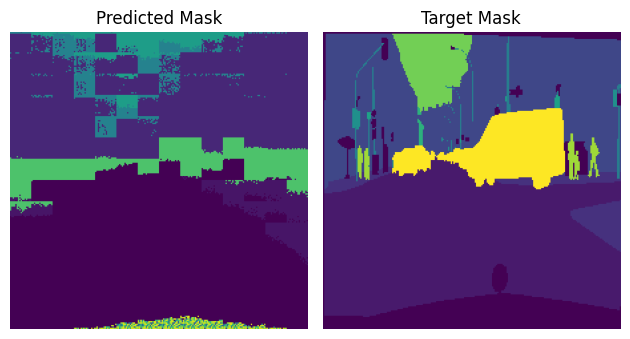

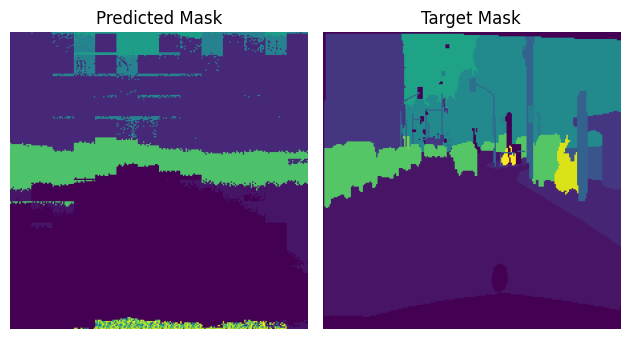

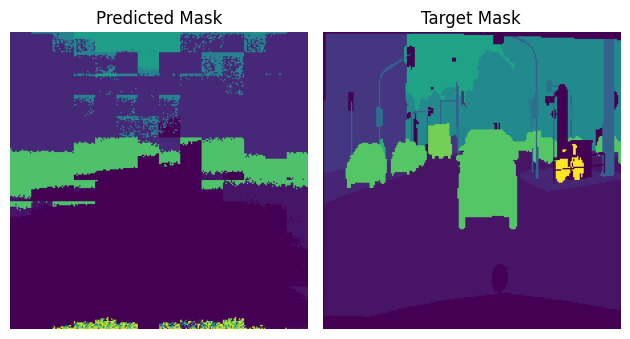

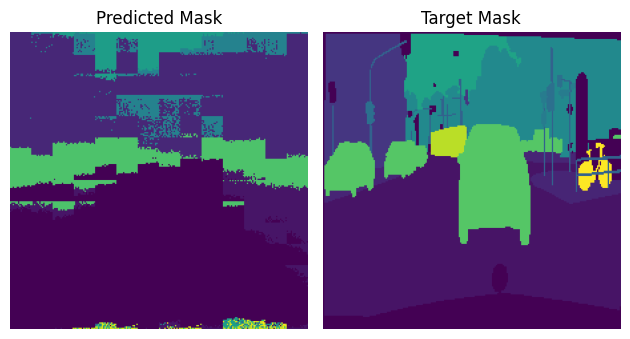

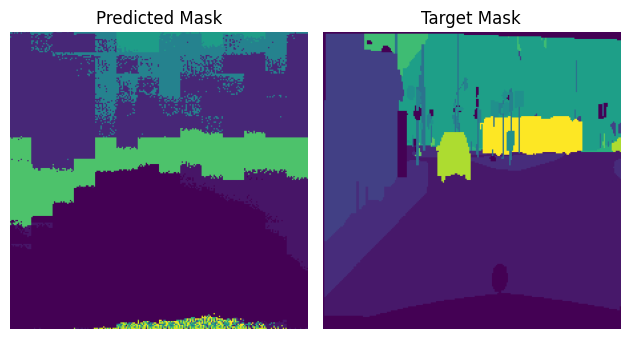

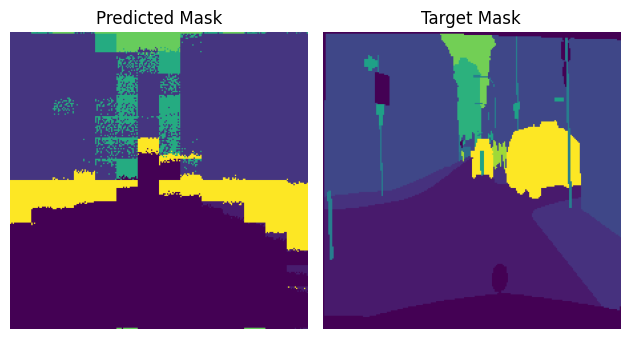

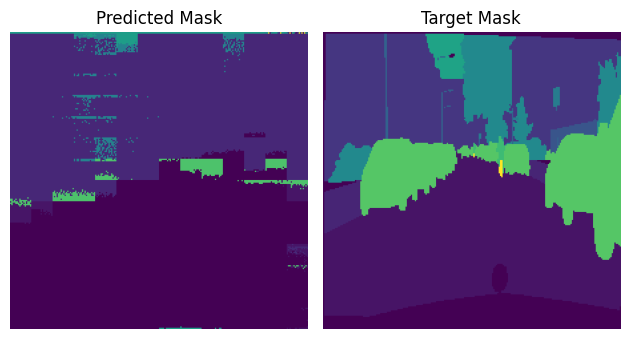

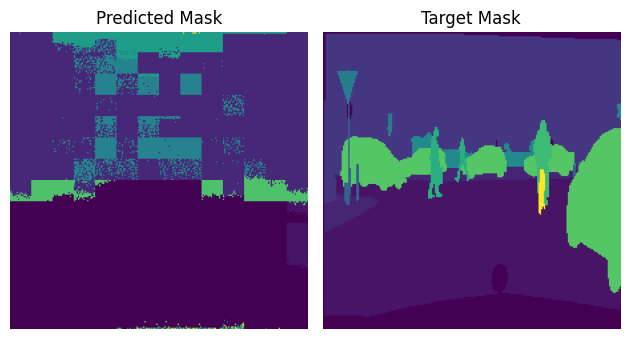

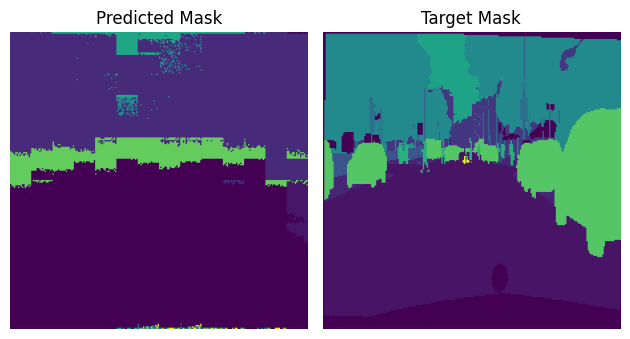

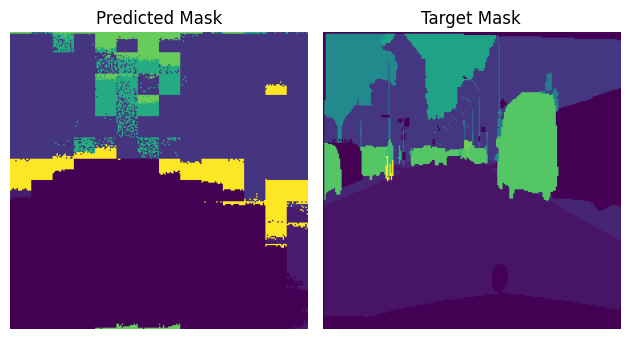

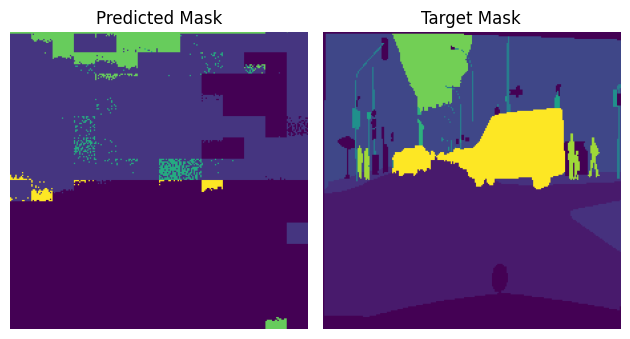

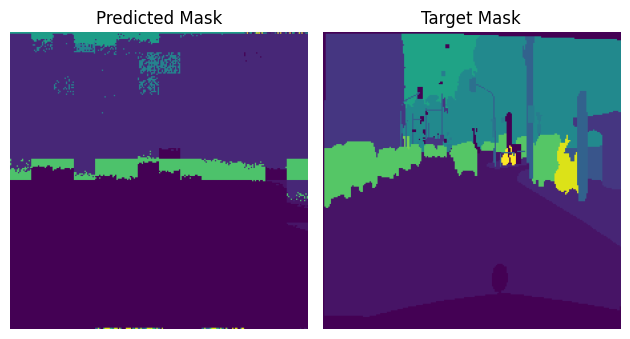

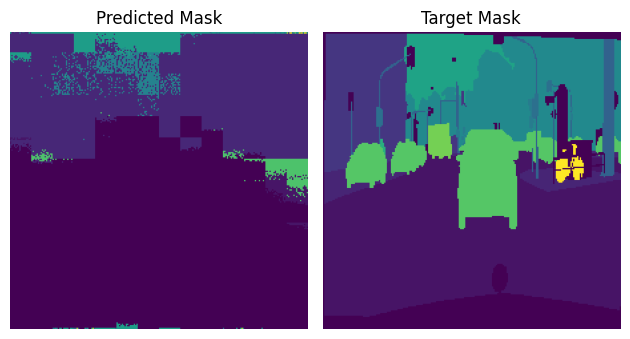

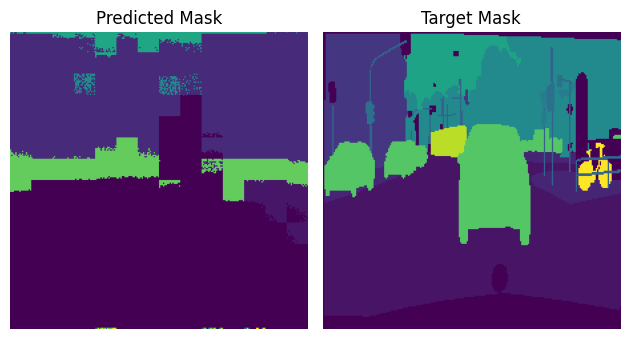

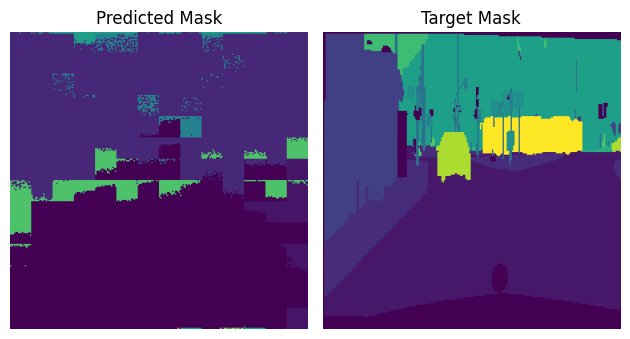

In [106]:
for t in TIME_STEPS:

    model = torch.load(os.path.join(MODEL_DIR, f"model_{int(t*100)}_patched.pt"))
    model = model.cpu().eval()
    model.eval()
    dataset = PatchedFeatureDataset(P_FEAT_DIR, DATA_DIR, "val", t)

    save_path = os.path.join("figs", f"out_masks_{int(t*100)}")
    os.makedirs(save_path, exist_ok=True)

    for i in range(10):
        feat, mask = dataset[i]
        feat, mask = feat.cpu(), mask.cpu().unsqueeze(0)
        pred = model(feat.unsqueeze(0)).argmax(dim=1)

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title("Predicted Mask")
        plt.imshow(pred.permute(1, 2, 0).numpy())
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Target Mask")
        plt.imshow(mask.permute(1, 2, 0).numpy())
        plt.axis("off")

        plt.savefig(os.path.join(save_path, f"val_mask_{i}"))
        plt.tight_layout()
        plt.show()

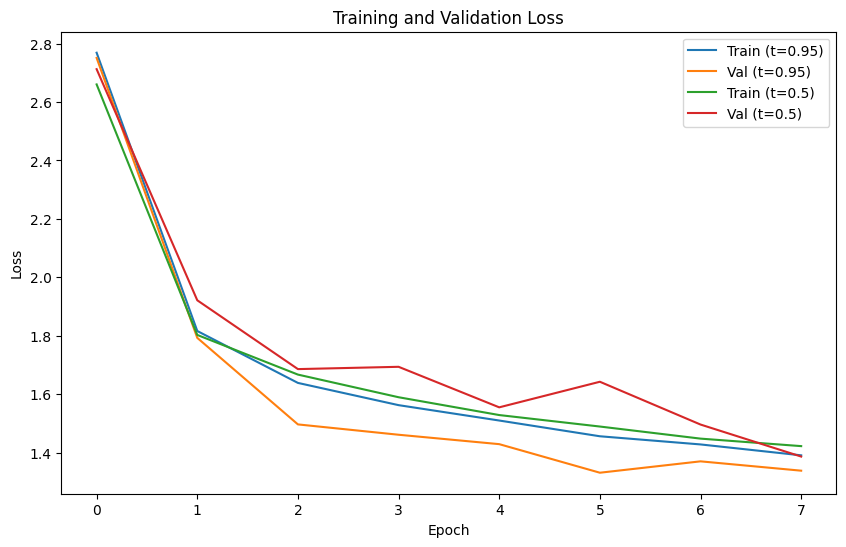

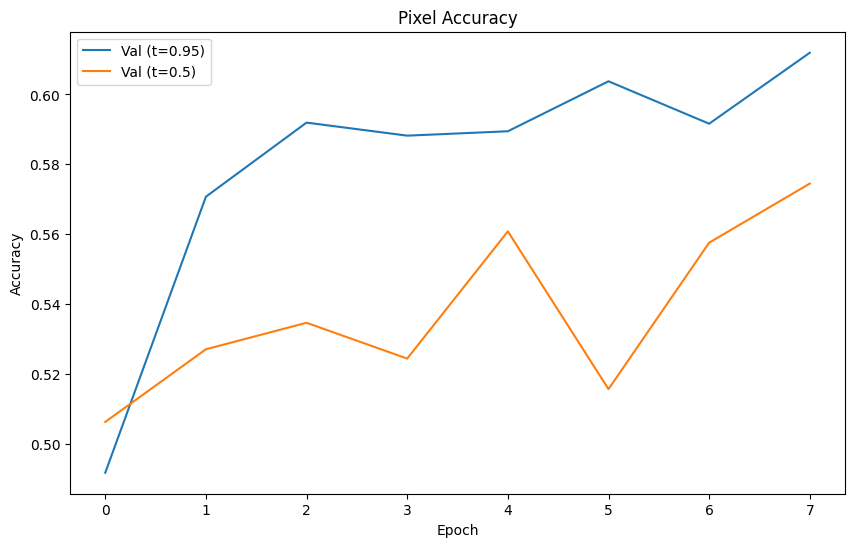

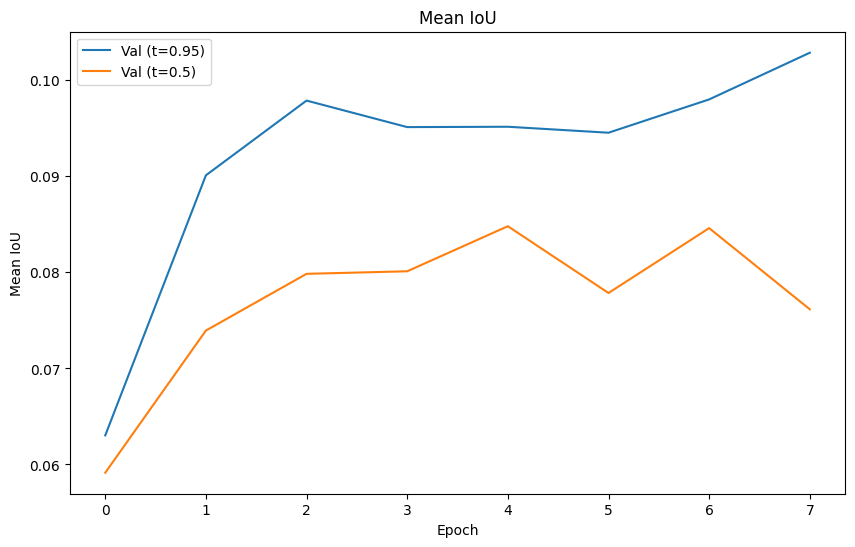

In [107]:
import json
import matplotlib.pyplot as plt
import os

METRIC_DIR = "train_metrics"

save_path = os.path.join("figs", "metric_plots")
os.makedirs(save_path, exist_ok=True)

metrics_data = {}
for timestep in TIME_STEPS:
    path = os.path.join(METRIC_DIR, f"metrics_{int(timestep*100)}_patched.json")
    with open(path, 'r') as f:
        metrics_data[timestep] = json.load(f)

# Plotting Losses
plt.figure(figsize=(10, 6))
plt.title("Training and Validation Loss")
for timestep, metrics in metrics_data.items():
    plt.plot(metrics['train_losses'], label=f'Train (t={timestep})')
    plt.plot(metrics['val_losses'], label=f'Val (t={timestep})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig(os.path.join(save_path, "losses"))
plt.show()

# Plotting Accuracies
plt.figure(figsize=(10, 6))
plt.title("Pixel Accuracy")
for timestep, metrics in metrics_data.items():
    plt.plot(metrics['val_accuracies'], label=f'Val (t={timestep})')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(os.path.join(save_path, "accuracy"))
plt.show()

# Plotting Mean IoUs
plt.figure(figsize=(10, 6))
plt.title("Mean IoU")
for timestep, metrics in metrics_data.items():
    plt.plot(metrics['val_mean_ious'], label=f'Val (t={timestep})')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()

plt.savefig(os.path.join(save_path, "meanIoU"))
plt.show()

In [108]:
!cp -r figs /content/drive/MyDrive/
!cp -r train_metrics /content/drive/MyDrive/